###  Consumer Price Index: A statistical analysis of the basket of goods and services in Canada

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams  
import seaborn as sns
import datetime as dt
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
import scipy.stats

# Dataset

In [2]:
#Importing the csv files for regions this project will cover
df_Can = pd.read_csv('1810000401_Canada.csv')
df_Alb = pd.read_csv('1810000401_Alberta.csv')
df_Ont = pd.read_csv('1810000401_Ontario.csv')

In [3]:
#Cleaning each dataset
df_Can = df_Can.drop(columns=['DGUID','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED', 'DECIMALS', 'UOM'])
df_Can = df_Can.rename(columns={'REF_DATE': 'year/month', 
                        'GEO': 'location',
                        'VALUE': 'CPI',
                       'Products and product groups': 'product group'})

In [4]:
#Cleaning each dataset
df_Alb = df_Alb.drop(columns=['DGUID','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED', 'DECIMALS', 'UOM'])
df_Alb = df_Alb.rename(columns={'REF_DATE': 'year/month', 
                        'GEO': 'location',
                        'VALUE': 'CPI',
                       'Products and product groups': 'product group'})

In [5]:
#Cleaning each dataset
df_Ont = df_Ont.drop(columns=['DGUID','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED', 'DECIMALS', 'UOM'])
df_Ont= df_Ont.rename(columns={'REF_DATE': 'year/month', 
                        'GEO': 'location',
                        'VALUE': 'CPI',
                       'Products and product groups': 'product group'})

In [6]:
#Concatenating all datasets along the rows
df_all = pd.concat([df_Can, df_Alb, df_Ont], axis=0)
df_all.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5850 entries, 0 to 1949
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year/month     5850 non-null   object 
 1   location       5850 non-null   object 
 2   product group  5850 non-null   object 
 3   CPI            5850 non-null   float64
dtypes: float64(1), object(3)
memory usage: 228.5+ KB


In [7]:
#converting the Year column of the joined dataset to the datetime format and using that as the index
df_all['year/month'].replace(regex=True, to_replace='-',value='')
df_all['year/month'] =  pd.to_datetime(df_all['year/month'], format='%Y%m', errors='ignore', infer_datetime_format=True)
#df_all = df_all.set_index(['year/month'])


In [8]:
#converting the Year column of the Canada dataset to the datetime format and using that as the index
df_Can['year/month'].replace(regex=True, to_replace='-',value='')
df_Can['year/month'] =  pd.to_datetime(df_Can['year/month'], format='%Y%m', errors='ignore', infer_datetime_format=True)
#df_Can = df_Can.set_index(['year/month'])


In [9]:
#converting the Year column of the Alberta dataset to the datetime format and using that as the index
df_Alb['year/month'].replace(regex=True, to_replace='-',value='')
df_Alb['year/month'] =  pd.to_datetime(df_Alb['year/month'], format='%Y%m', errors='ignore', infer_datetime_format=True)
#df_Alb = df_Alb.set_index(['year/month'])


In [10]:
#converting the Year column of the Ontario dataset to the datetime format and using that as the index
df_Ont['year/month'].replace(regex=True, to_replace='-',value='')
df_Ont['year/month'] =  pd.to_datetime(df_Ont['year/month'], format='%Y%m', errors='ignore', infer_datetime_format=True)
#df_Ont = df_Ont.set_index(['year/month'])

### ARIMA: 

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model used for analyzing and forecasting time series data. It combines three components: autoregression (AR), differencing for integration (I), and moving average (MA). ARIMA is particularly effective for time series data that exhibit non-stationarity (i.e., data whose statistical properties, like mean and variance, change over time).
Components of ARIMA:

    AutoRegressive (AR):
        Refers to the use of past values of the variable to predict its future values.
        The model assumes a linear relationship between the current value and its lagged values.
        Represented by the parameter p (number of lagged observations used in the model).

    Integrated (I):
        Refers to the process of differencing the data to make it stationary (removing trends or seasonality).
        The degree of differencing is represented by the parameter d.

    Moving Average (MA):
        Involves modeling the relationship between the current value of the series and past forecast errors.
        Represented by the parameter q (number of past errors included in the model).

The ARIMA Model:

ARIMA is typically denoted as ARIMA(p, d, q):

    p: Number of lag observations in the AR component.
    d: Number of times the data needs to be differenced to achieve stationarity.
    q: Number of lagged forecast errors in the MA component.

Key Assumptions:

    The time series data should be stationary (or made stationary via differencing).
    There should be no strong seasonal patterns (a variant called SARIMA handles seasonality).

###  Auto_ARIMA


In [62]:
df = pd.read_csv('1810000401_Canada.csv')
df = df.drop(columns=['DGUID','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED', 'DECIMALS', 'UOM', 'GEO', 'Products and product groups'])
df['REF_DATE'].replace(regex=True,inplace=True, to_replace='M',value='')
df['REF_DATE'] =  pd.to_datetime(df['REF_DATE'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['REF_DATE'])

In [63]:
# Test stationarity for model selection

from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df_Can.CPI)

Test Statistic                   -4.833853
p-value                           0.000047
#Lags Used                        8.000000
Number of Observations Used    1941.000000
Critical Value (1%)              -3.433724
Critical Value (5%)              -2.863030
Critical Value (10%)             -2.567563
dtype: float64

In [64]:
!pip install pmdarima
from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13493.246, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12950.432, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13495.094, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12731.908, Time=1.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12729.911, Time=1.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=12949.160, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.85 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12731.908, Time=1.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=12733.591, Time=3.79 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : A

In [65]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                VALUE   No. Observations:                 1950
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -6072.748
Date:                              Sun, 11 Dec 2022   AIC                          12151.496
Time:                                      20:38:34   BIC                          12168.182
Sample:                                           0   HQIC                         12157.635
                                             - 1950                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.016      0.201      0.841      -0.029       0.035
ma.S.L12      -1.00

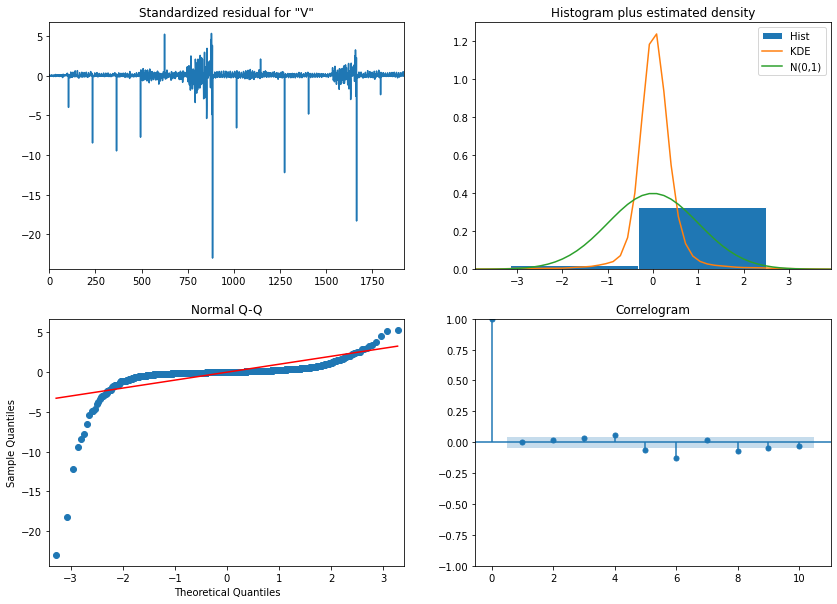

In [66]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

### Time Series Forcasting by ARIMA Model (optimising p,d,q parameters) of Alberta Province

In [67]:
df_Alb.head() 

,year/month,location,product group,CPI
0,2012-01-01,Alberta,All-items,127.1
1,2012-02-01,Alberta,All-items,126.6
2,2012-03-01,Alberta,All-items,126.6
3,2012-04-01,Alberta,All-items,127.0
4,2012-05-01,Alberta,All-items,126.6


In [68]:
Alb_All = df_Alb.loc[df_Alb['product group'] == 'All-items']
Alb_TS=Alb_All['CPI']
Alb_TS=pd.DataFrame(Alb_TS)
Alb_TS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     130 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [69]:
#Let's check whether the time series are regular (i.e. whether the time between any two observations remains the same).
Alb_TS.index.to_series().diff().value_counts()

1.0    129
dtype: int64

As we can see, the dataset time series contains small irregularities caused by the unequal length of the calendar months.

To check whether the time series is stationary or non-stationary:

In [70]:
# Checking the actual value of p against level of significance 0.5 using adfuller
from statsmodels.tsa.stattools import adfuller
from numpy import log
y=Alb_TS['CPI'].astype(int)
result = adfuller(y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.773520
p-value: 1.000000


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

    p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.Clearly the value of p is more than the level of significance. Therefore we need to increase the order and check the values of d, p, q for best fit.

In [71]:
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

Finding the value of the d parameter 

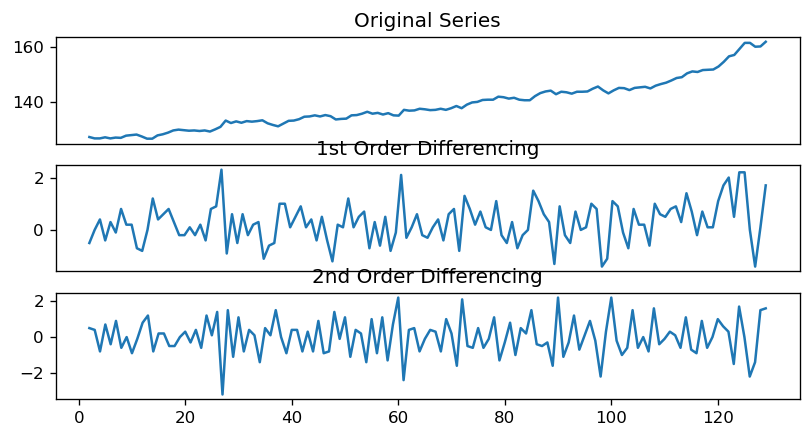

In [72]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(Alb_TS.CPI); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(Alb_TS.CPI.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(Alb_TS.CPI.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Here we can see how the time series has become stationary. One thing which is noticeable here is in first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. So we can select 1st order differencing for our model. We can also verify this using an autocorrelation plot. 

Finding the value of p and q parameters:


In [73]:
y=Alb_TS['CPI'].astype(int)
z=y.copy()
z=pd.Series(z, name='value')
z=z.to_frame()

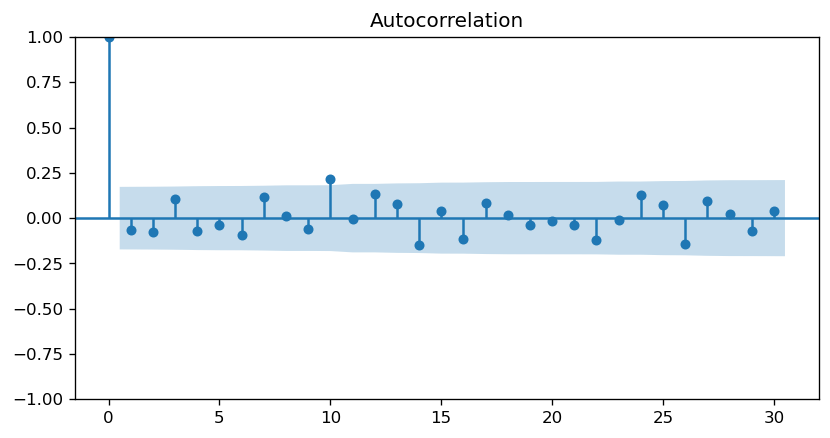

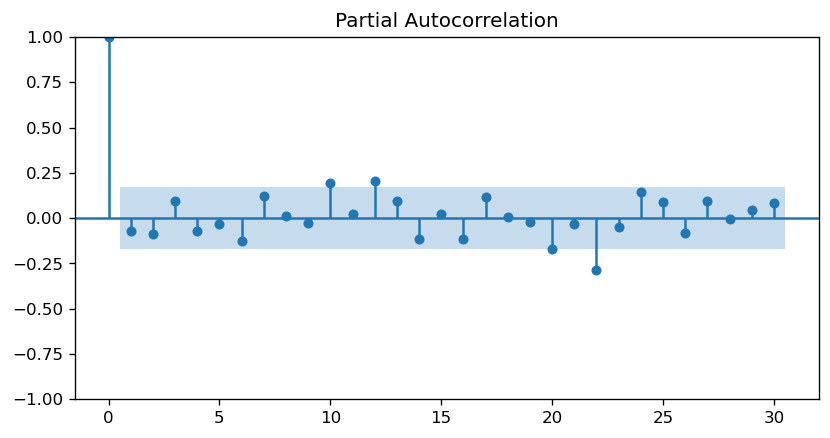

In [74]:
p1 = tsaplots.plot_acf(z.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(z.diff().dropna(), lags=30, alpha=0.05)
plt.show()

Here we can see that the first lag is significantly out of the limit and the second one is within the significant limit so we can select the order of the p as 1. 

Here we can see that the 2nd lag is within the significance limit so we can say that the optimal value of our q (MA) is 1. 

### Building ARIMA model

In [75]:
#We will split the data into "training" and "validation" sets, using approximately 70% of the data for training.
n = np.int(len(Alb_TS) * 0.7)
train, test = Alb_TS.iloc[:n], Alb_TS.iloc[n:]

In [76]:
y=Alb_TS['CPI'].astype(int)
z=y.copy()
z=pd.Series(z, name='value')
z=z.to_frame()

In [77]:
# 1,1,1 ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
# 1,1,1 ARIMA Model

model = ARIMA(z.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -169.938
Date:                Sun, 11 Dec 2022   AIC                            345.876
Time:                        20:38:36   BIC                            354.455
Sample:                             0   HQIC                           349.362
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.021     47.258      0.000       0.956       1.038
ma.L1         -0.9731      0.055    -17.564      0.000      -1.082      -0.865
sigma2         0.8098      0.102      7.961      0.0

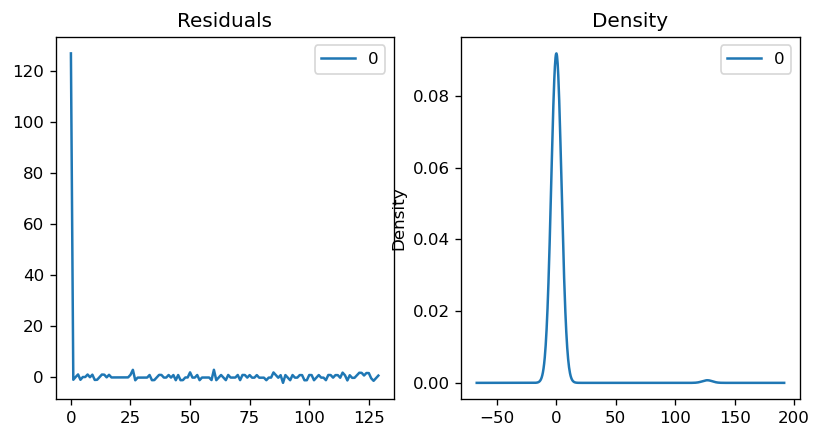

In [78]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:>

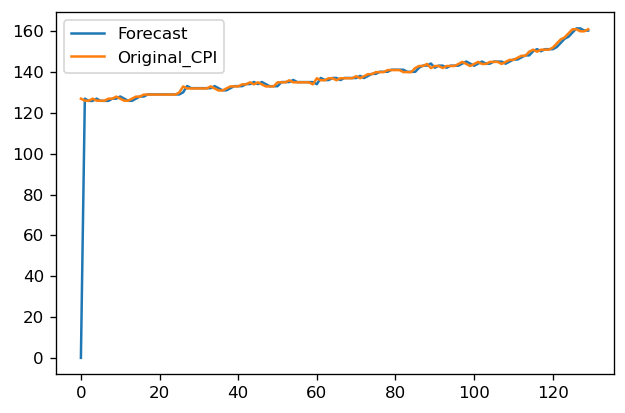

In [79]:

# # Actual vs Fitted
Forecast=model_fit.predict(dynamic=False)
dict1 = {'Original_CPI':y, 'Forecast':Forecast}
df_forecast=pd.DataFrame(dict1)
df_forecast[['Forecast','Original_CPI']].plot(figsize=(6,4))

Now we will forecast across the whole testing set. We will do out-of-sample forecasting by iteratively predicting the next point of the test series, and appending this prediction to the history. This approach for long-term forecasting is implemented in the forecast function.

predicted=142.887814, expected=143.000000
predicted=142.975011, expected=142.000000
predicted=142.171538, expected=143.000000
predicted=142.854070, expected=143.000000
predicted=142.962805, expected=143.000000
predicted=142.990365, expected=144.000000
predicted=143.809486, expected=145.000000
predicted=144.791322, expected=144.000000
predicted=144.111071, expected=143.000000
predicted=143.189606, expected=144.000000
predicted=143.912871, expected=145.000000
predicted=144.786475, expected=144.000000
predicted=144.075839, expected=144.000000
predicted=144.036727, expected=145.000000
predicted=144.828904, expected=145.000000
predicted=144.917904, expected=145.000000
predicted=144.960506, expected=144.000000
predicted=144.166497, expected=145.000000
predicted=144.887744, expected=146.000000
predicted=145.757554, expected=146.000000
predicted=145.880109, expected=147.000000
predicted=146.769111, expected=148.000000
predicted=147.746492, expected=148.000000
predicted=147.895564, expected=150

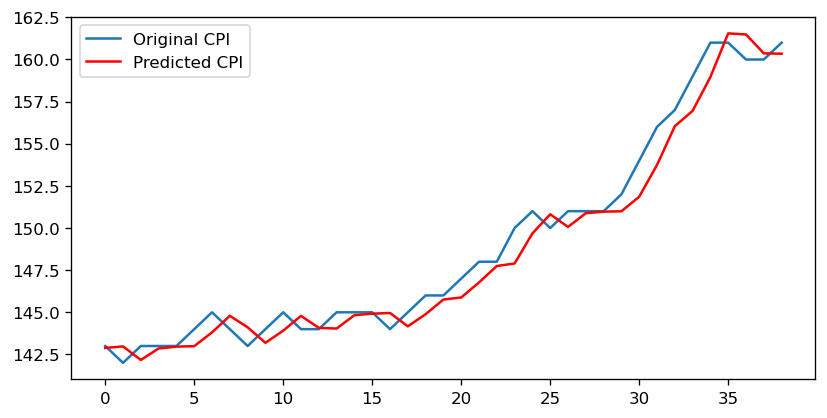

None


In [80]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
size = int(len(y) * 0.70)
train, test = y[0:size], y[size:len(y)].reset_index(drop=True)
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test, label='Original CPI')
pyplot.plot(predictions, color='red', label='Predicted CPI')
#plt.legend()
plt.legend(loc="upper left")

pyplot.show()
print (pyplot.show())

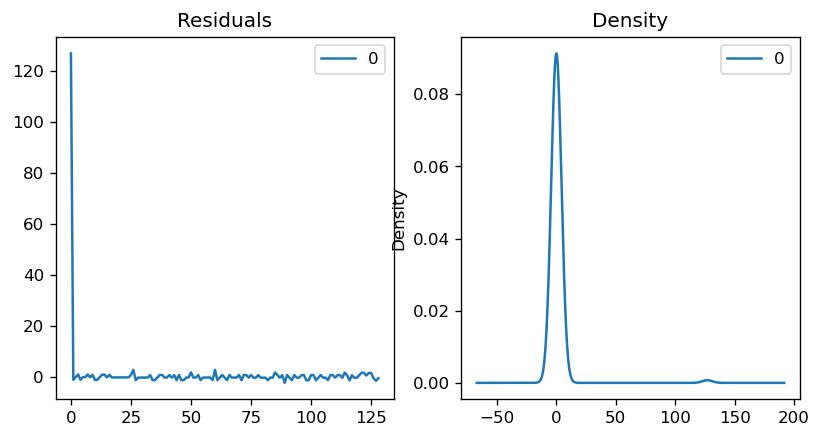

In [81]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [82]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -168.866
Date:                Sun, 11 Dec 2022   AIC                            343.731
Time:                        20:38:40   BIC                            352.288
Sample:                             0   HQIC                           347.208
                                - 129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.019     51.883      0.000       0.960       1.035
ma.L1         -0.9763      0.053    -18.303      0.000      -1.081      -0.872
sigma2         0.8128      0.103      7.903      0.0

Interpretation of ARIMA model in Alberta dataset:
To analyze ARIMA results, we need to determine if the model meets the assumptions using Jlung-Box chi-square statistics and autocorrelation of residuals; understand if each term is significant using p-values, and recognize if the model fits well using mean-squared error.
Determine Term Significance
We want to make sure each term in our model is statistically significant. The null for this section is that each coefficient is NOT statistically significant. Therefore, we want each term to have a p-value of less than 0.05, so we can reject the null hypothesis with statistically significant values. In this dataset, as their p-values are below the 0.05 threshold, sowe reject the null hypothesis.
Review Assumptions
Next, we want to make sure our model meets the assumption that the residuals are independent, known as white noise.If the residuals are not independent, we can extract the non-randomness to make a better model.
Ljung-Box: The Ljung Box test, pronounced “Young” and sometimes called the modified Box-Pierce test, tests that the errors are white noise. The Ljung-Box (L1) (Q) is the LBQ test statistic at lag 1 is, the Prob(Q) is 1.13, and the p-value is 0.29. Since the probability is above 0.05, we can’t reject the null that the errors are white noise.
Heteroscedasticity
Heteroscedasticity tests that the error residuals are homoscedastic or have the same variance. The summary performs White’s test. Our summary statistics show a test statistic of 1.55 and a p-value of 0.16, which means we reject the null hypothesis and our residuals show variance.
Jarque-Bera
Jarque-Bera tests for the normality of errors. It tests the null that the data is normally distributed against an alternative of another distribution. We see a test statistic of 3.04 with a probability of 0.22. Also, as part of the Jarque-Bera test, we see the distribution has a slight positive skew and a small kurtosis.
Log-Likelihood
The log-likelihood function identifies a distribution that fits best with the sampled data. While it’s useful, AIC and BIC punish the model for complexity, which helps make our ARIMA model parsimonious.
Akaike’s Information Criterion (AIC) helps determine the strength of the linear regression model. The AIC penalizes a model for adding parameters since adding more parameters will always increase the maximum likelihood value.


#### We conclude that this ARIMA model (p,d,q=1,1,1) works well for forcasting CPI values as the model efficiently meets the assumptions using p-values, residual errors and mean-squared error. 
 

### Forcasting of CPI value in Ontario (df_Ont dataset)

In [83]:
df_Ont

,year/month,location,product group,CPI
0,2012-01-01,Ontario,All-items,120.6
1,2012-02-01,Ontario,All-items,121.4
2,2012-03-01,Ontario,All-items,122.0
3,2012-04-01,Ontario,All-items,122.4
4,2012-05-01,Ontario,All-items,122.4
...,...,...,...,...
1945,2022-06-01,Ontario,Services,166.4
1946,2022-07-01,Ontario,Services,167.8
1947,2022-08-01,Ontario,Services,167.7
1948,2022-09-01,Ontario,Services,168.3


In [84]:
Ont_All = df_Ont.loc[df_Ont['product group'] == 'All-items']
Ont_TS=Ont_All['CPI']
Ont_TS=pd.DataFrame(Ont_TS)
Ont_TS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     130 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [85]:
#To check whether the time series is stationary or non-stationary:
# Checking the actual value of p against level of significance 0.5 using adfuller
y1=Ont_TS['CPI'].astype(int)
result = adfuller(y1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.364462
p-value: 0.998993


So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.Clearly the value of p is more than the level of significance. Therefore we need to increase the order and check the values of d, p, q for best fit.

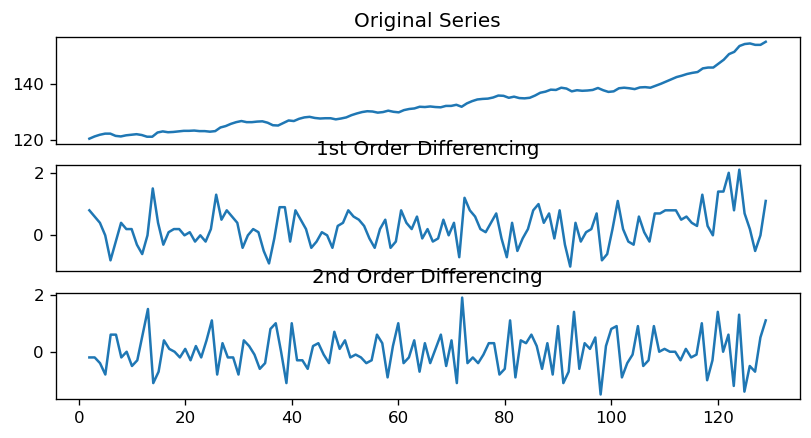

In [86]:
#Finding the value of the d parameter 
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(Ont_TS.CPI); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(Ont_TS.CPI.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(Ont_TS.CPI.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [87]:
y1=Ont_TS['CPI'].astype(int)
g=y1.copy()
g=pd.Series(g, name='value')
g=g.to_frame()

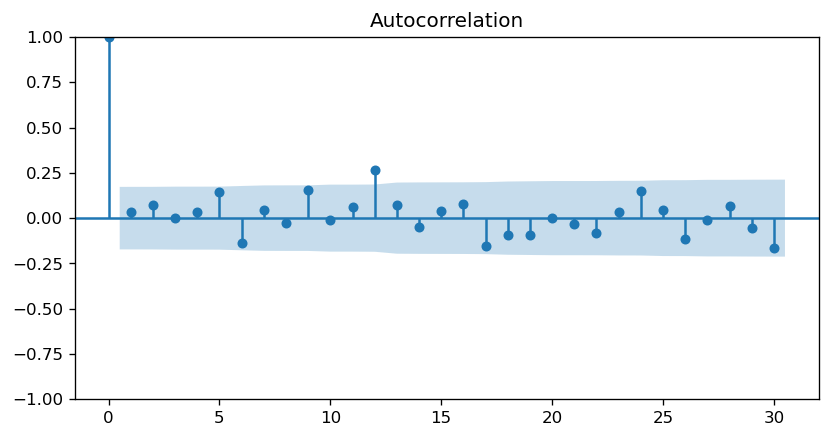

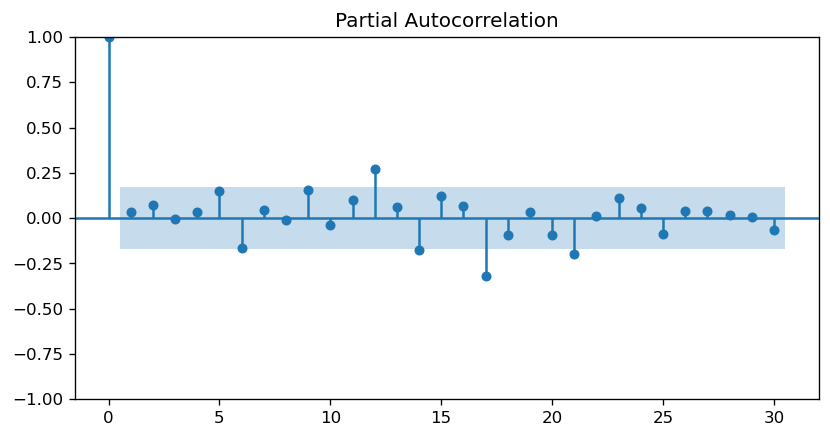

In [88]:
#Finding the value of p and q parameters:
p1 = tsaplots.plot_acf(g.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(g.diff().dropna(), lags=30, alpha=0.05)
plt.show()


In [89]:
model = ARIMA(g.value, order=(1,1,1))
model_fit1 = model.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -129.240
Date:                Sun, 11 Dec 2022   AIC                            264.480
Time:                        20:38:41   BIC                            273.060
Sample:                             0   HQIC                           267.966
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9953      0.013     75.961      0.000       0.970       1.021
ma.L1         -0.9433      0.048    -19.710      0.000      -1.037      -0.850
sigma2         0.4299      0.064      6.735      0.0

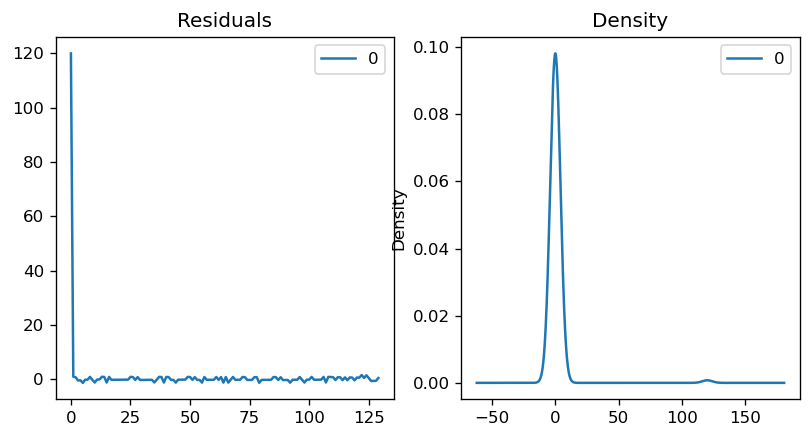

In [90]:
# Plot residual errors
residuals = pd.DataFrame(model_fit1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:>

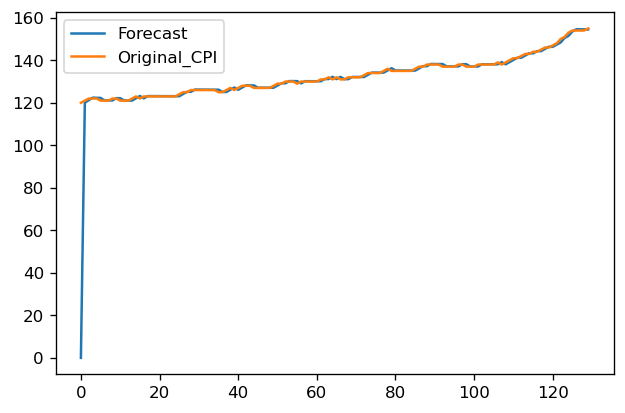

In [91]:
# # Actual vs Fitted
Forecast=model_fit1.predict(dynamic=False)
dict1 = {'Original_CPI':y1, 'Forecast':Forecast}
df_forecast=pd.DataFrame(dict1)
df_forecast[['Forecast','Original_CPI']].plot(figsize=(6,4))

predicted=135.000046, expected=136.000000
predicted=135.969948, expected=137.000000
predicted=136.999393, expected=137.000000
predicted=137.000000, expected=138.000000
predicted=138.016167, expected=138.000000


C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=138.180032, expected=138.000000
predicted=138.027475, expected=138.000000
predicted=137.974915, expected=137.000000
predicted=136.996787, expected=137.000000
predicted=137.002935, expected=137.000000


C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=137.157926, expected=137.000000
predicted=137.002454, expected=138.000000
predicted=138.029763, expected=138.000000
predicted=137.973005, expected=137.000000
predicted=137.000005, expected=137.000000
predicted=137.000000, expected=137.000000
predicted=137.000000, expected=138.000000
predicted=137.999991, expected=138.000000
predicted=138.000000, expected=138.000000
predicted=138.000000, expected=138.000000
predicted=138.000000, expected=138.000000
predicted=138.000000, expected=139.000000
predicted=138.999991, expected=138.000000
predicted=138.014410, expected=139.000000
predicted=138.930100, expected=140.000000
predicted=139.972723, expected=141.000000
predicted=141.000000, expected=141.000000
predicted=141.000000, expected=142.000000
predicted=142.065017, expected=143.000000
predicted=143.186388, expected=143.000000


C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=143.184757, expected=144.000000


C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=144.192330, expected=144.000000
predicted=144.190530, expected=145.000000
predicted=145.198112, expected=146.000000
predicted=146.205408, expected=146.000000
predicted=146.203259, expected=147.000000
predicted=147.210669, expected=148.000000
predicted=148.242421, expected=150.000000
predicted=150.372381, expected=151.000000
predicted=151.451381, expected=153.000000
predicted=153.688480, expected=154.000000
predicted=154.737606, expected=154.000000
predicted=154.622446, expected=154.000000
predicted=154.545426, expected=154.000000
predicted=154.489732, expected=155.000000
Test RMSE: 0.743


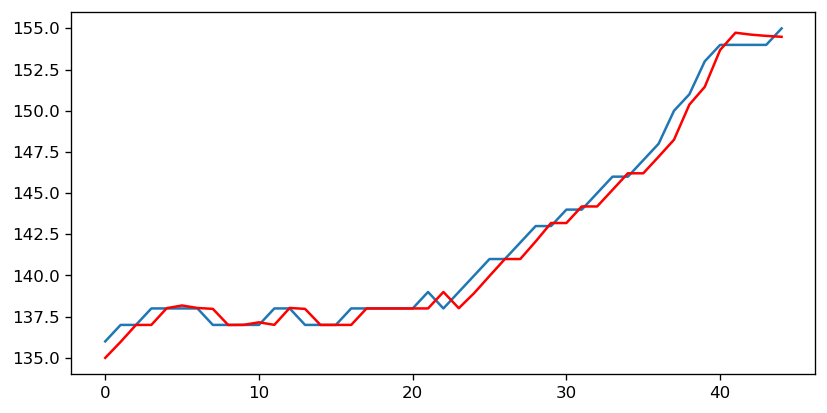

In [92]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
size = int(len(y1) * 0.66)
train, test = y1[0:size], y1[size:len(y1)].reset_index(drop=True)
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test, label='Original CPI')
pyplot.plot(predictions, color='red', label='Predicted CPI')
pyplot.show()

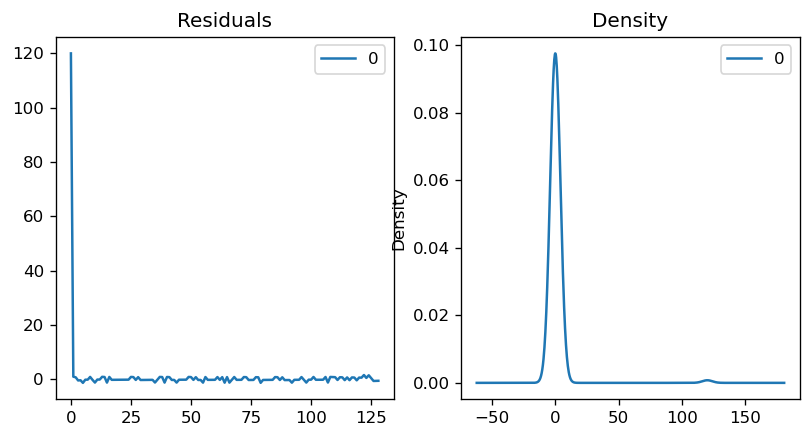

In [93]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [94]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.451
Date:                Sun, 11 Dec 2022   AIC                            262.902
Time:                        20:38:48   BIC                            271.458
Sample:                             0   HQIC                           266.379
                                - 129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9956      0.013     79.082      0.000       0.971       1.020
ma.L1         -0.9484      0.046    -20.402      0.000      -1.039      -0.857
sigma2         0.4314      0.064      6.695      0.0

### Forecasting of CPI value of Canada
df_Can

In [95]:
df_Can

,year/month,location,product group,CPI,bc_CPI
0,2012-01-01,Canada,All-items,120.7,2.043551
1,2012-02-01,Canada,All-items,121.2,2.044087
2,2012-03-01,Canada,All-items,121.7,2.044621
3,2012-04-01,Canada,All-items,122.2,2.045151
4,2012-05-01,Canada,All-items,122.1,2.045045
...,...,...,...,...,...
1945,2022-06-01,Canada,Services,162.7,2.079980
1946,2022-07-01,Canada,Services,164.2,2.081028
1947,2022-08-01,Canada,Services,164.3,2.081097
1948,2022-09-01,Canada,Services,164.8,2.081443


In [96]:
Can_All = df_Can.loc[df_Can['product group'] == 'All-items']
Can_TS=Can_All['CPI']
Can_TS=pd.DataFrame(Can_TS)
Can_TS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     130 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [97]:
# Checking the actual value of p against level of significance 0.5 using adfuller

y2=Can_TS['CPI'].astype(int)
result = adfuller(y2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.337394
p-value: 0.998978


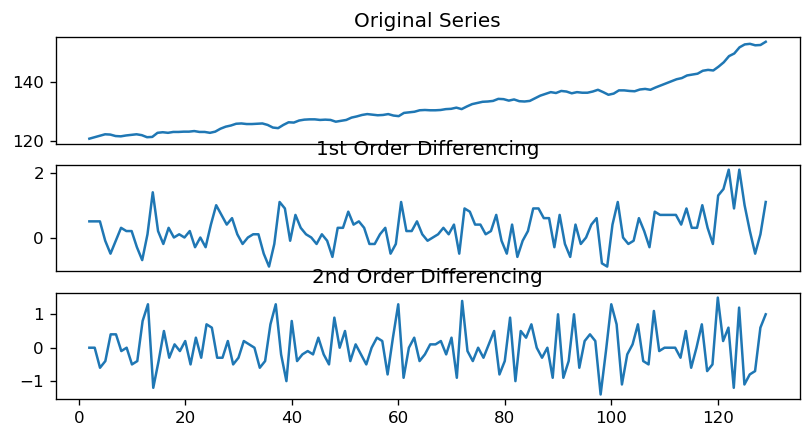

In [98]:
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(Can_TS.CPI); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(Can_TS.CPI.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(Can_TS.CPI.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [99]:
y2=Can_TS['CPI'].astype(int)
c=y2.copy()
c=pd.Series(c, name='value')
c=c.to_frame()

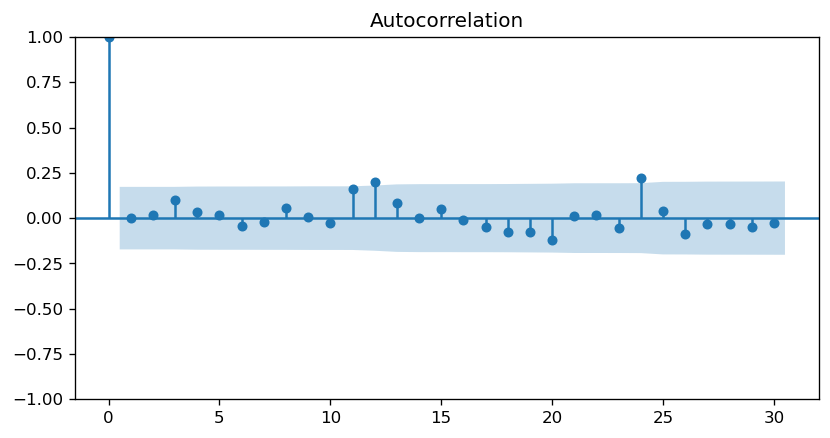

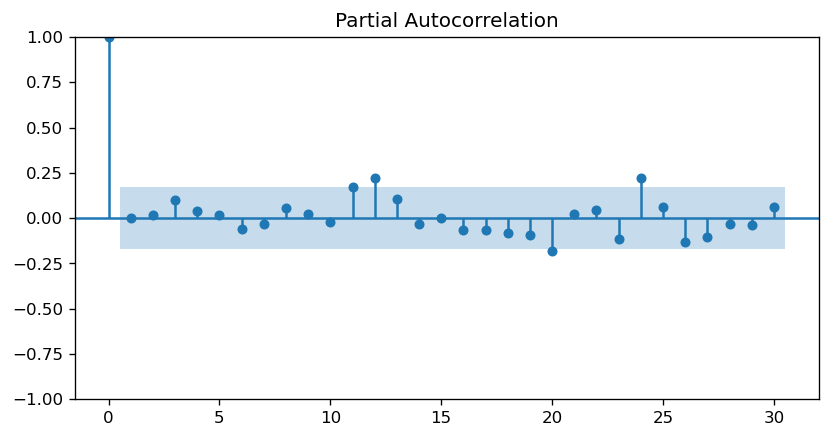

In [100]:
p1 = tsaplots.plot_acf(c.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(c.diff().dropna(), lags=30, alpha=0.05)
plt.show()

In [101]:
#We will split the data into "training" and "validation" sets, using approximately 70% of the data for training.
n = np.int(len(Can_TS) * 0.7)
train, test = Can_TS.iloc[:n], Can_TS.iloc[n:]

In [102]:
model = ARIMA(c.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -132.836
Date:                Sun, 11 Dec 2022   AIC                            271.672
Time:                        20:38:50   BIC                            280.252
Sample:                             0   HQIC                           275.158
                                - 130                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9958      0.013     75.019      0.000       0.970       1.022
ma.L1         -0.9520      0.041    -23.417      0.000      -1.032      -0.872
sigma2         0.4547      0.065      6.961      0.0

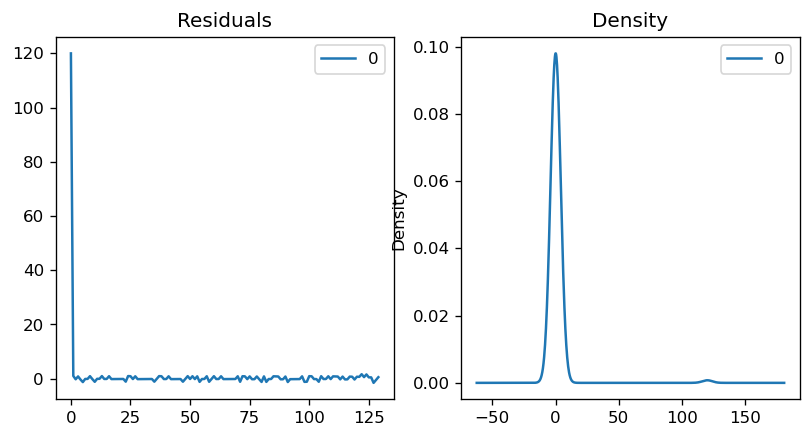

In [103]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:>

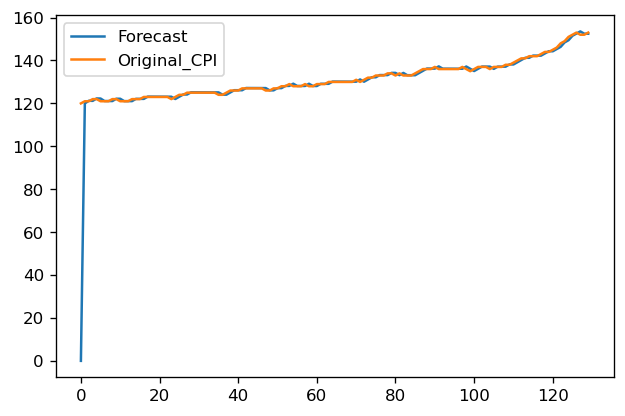

In [104]:
# # Actual vs Fitted
Forecast=model_fit.predict(dynamic=False)
dict1 = {'Original_CPI':y2, 'Forecast':Forecast}
df_forecast=pd.DataFrame(dict1)
df_forecast[['Forecast','Original_CPI']].plot(figsize=(6,4))

predicted=136.943496, expected=136.000000
predicted=136.081154, expected=136.000000
predicted=136.001807, expected=136.000000
predicted=136.000042, expected=136.000000
predicted=136.000001, expected=136.000000
predicted=136.000000, expected=136.000000
predicted=136.000000, expected=137.000000
predicted=136.919592, expected=136.000000
predicted=136.101580, expected=135.000000
predicted=135.087152, expected=136.000000
predicted=135.916776, expected=137.000000
predicted=136.900710, expected=137.000000
predicted=136.971549, expected=137.000000
predicted=136.991764, expected=136.000000
predicted=136.077051, expected=137.000000
predicted=136.928296, expected=137.000000
predicted=136.977726, expected=137.000000
predicted=136.992981, expected=138.000000
predicted=137.898054, expected=138.000000
predicted=137.971121, expected=139.000000
predicted=138.902521, expected=140.000000
predicted=139.918020, expected=141.000000
predicted=140.952052, expected=141.000000
predicted=140.995747, expected=142

C:\Users\harvi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=144.187009, expected=144.000000
predicted=144.185349, expected=145.000000
predicted=144.980000, expected=146.000000
predicted=146.000000, expected=148.000000
predicted=148.329763, expected=149.000000
predicted=149.391648, expected=151.000000
predicted=151.597805, expected=152.000000
predicted=152.660559, expected=153.000000
predicted=153.709069, expected=152.000000
predicted=152.483912, expected=152.000000
predicted=152.439930, expected=153.000000
Test RMSE: 0.846


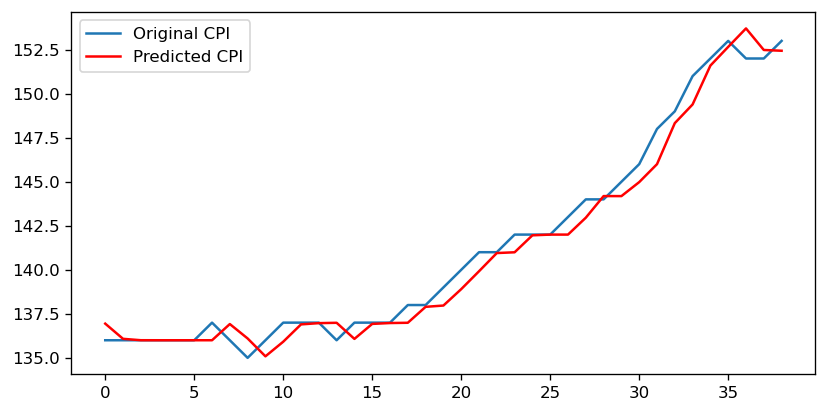

None


In [105]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
size = int(len(y2) * 0.70)
train, test = y2[0:size], y2[size:len(c)].reset_index(drop=True)
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test, label='Original CPI')
pyplot.plot(predictions, color='red', label='Predicted CPI')
#plt.legend()
plt.legend(loc="upper left")

pyplot.show()
print (pyplot.show())

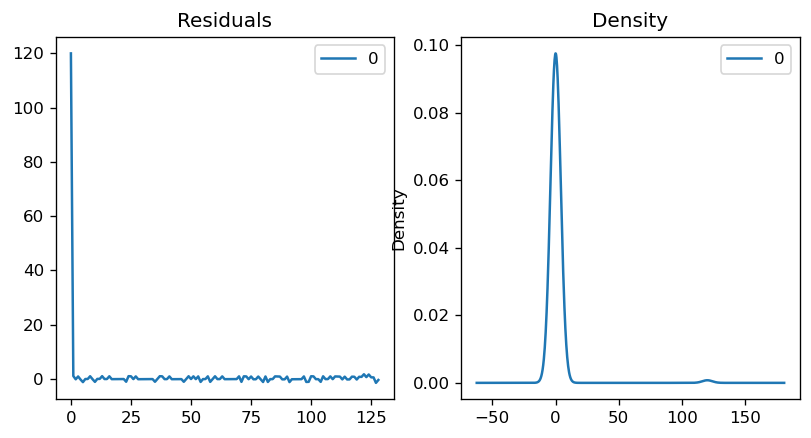

In [106]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(8,4))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [107]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -131.978
Date:                Sun, 11 Dec 2022   AIC                            269.957
Time:                        20:38:54   BIC                            278.513
Sample:                             0   HQIC                           273.433
                                - 129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9961      0.013     78.754      0.000       0.971       1.021
ma.L1         -0.9567      0.039    -24.412      0.000      -1.034      -0.880
sigma2         0.4560      0.066      6.941      0.0